In [1]:
import numpy as np
import os

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,  Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# model evaluation libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_dir= "/kaggle/input/files1/Malaria Cells"
training_dir= "/kaggle/input/files1/Malaria Cells/training_set"
testing_dir= "/kaggle/input/files1/Malaria Cells/testing_set"

print("inside base dir :", os.listdir(base_dir))
print("\ntraining_set :", os.listdir(training_dir))
print("\ntesting_set :", os.listdir(testing_dir))

inside base dir : ['testing_set', 'single_prediction', 'training_set']

training_set : ['Uninfected', 'Parasitized']

testing_set : ['Uninfected', 'Parasitized']


In [3]:
train_Uninfected= "/kaggle/input/files1/Malaria Cells/training_set/Uninfected"
train_Parasitized= "/kaggle/input/files1/Malaria Cells/training_set/Parasitized"

test_Uninfected= "/kaggle/input/files1/Malaria Cells/testing_set/Uninfected"
test_Parasitized= "/kaggle/input/files1/Malaria Cells/testing_set/Parasitized"

print("train_Uninfected:", os.listdir(train_Uninfected)[:5])
print("\ntrain_Parasitized:", os.listdir(train_Parasitized)[:5])
print("\ntest_Uninfected:", os.listdir(test_Uninfected)[:5])
print("\ntest_Parasitized:", os.listdir(test_Parasitized)[:5])


train_Uninfected: ['C203ThinF_IMG_20151029_102123_cell_51.png', 'C238NThinF_IMG_20151207_114038_cell_84.png', 'C119P80ThinF_IMG_20151002_124304_cell_112.png', 'C39P4thinF_original_IMG_20150622_111723_cell_33.png', 'C101P62ThinF_IMG_20150918_151149_cell_63.png']

train_Parasitized: ['C99P60ThinF_IMG_20150918_141001_cell_93.png', 'C99P60ThinF_IMG_20150918_141001_cell_133.png', 'C101P62ThinF_IMG_20150918_151942_cell_60.png', 'C162P123ThinF_IMG_20151116_102655_cell_163.png', 'C52P13thinF_IMG_20150725_124830_cell_174.png']

test_Uninfected: ['C119P80ThinF_IMG_20151002_124304_cell_112.png', 'C101P62ThinF_IMG_20150918_151149_cell_63.png', 'C180P141NThinF_IMG_20151201_165601_cell_115.png', 'C95P56ThinF_IMG_20150821_171603_cell_75.png', 'C125P86ThinF_IMG_20151004_102053_cell_83.png']

test_Parasitized: ['C99P60ThinF_IMG_20150918_141001_cell_93.png', 'C99P60ThinF_IMG_20150918_141001_cell_133.png', 'C101P62ThinF_IMG_20150918_151942_cell_60.png', 'C52P13thinF_IMG_20150725_124830_cell_174.png', 'C4

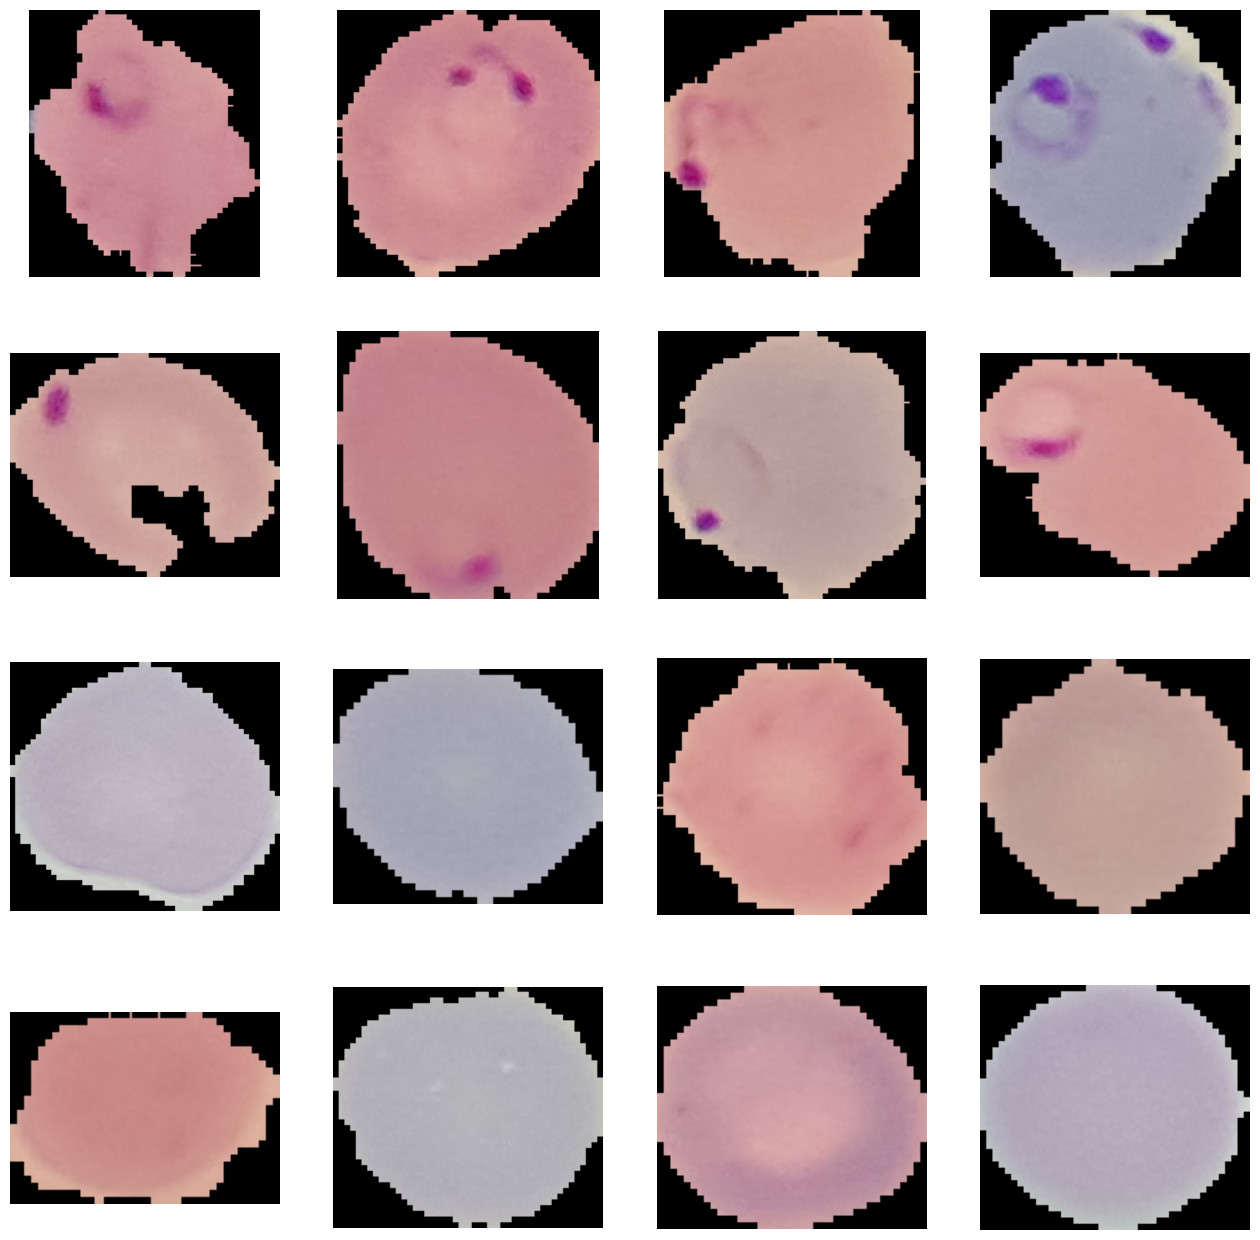

In [4]:
nrows = 4
ncols = 4

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

parasitized_cell = [os.path.join(train_Parasitized, image) for image in os.listdir(train_Parasitized)[pic_index-8:pic_index]]

uninfected_cell = [os.path.join(train_Uninfected, image) for image in os.listdir(train_Uninfected)[pic_index-8:pic_index]]

for i, image_path in enumerate(parasitized_cell+uninfected_cell):

  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 

  img = mpimg.imread(image_path)
  plt.imshow(img)

plt.show()

In [5]:
parasitized_image= imread("/kaggle/input/files1/Malaria Cells/training_set/Parasitized/C99P60ThinF_IMG_20150918_141001_cell_93.png")
parasitized_image.shape

(151, 130, 3)

In [6]:
# generating training set
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

train_data= train_datagen.flow_from_directory(training_dir,
                                              target_size= (100,100),
                                              batch_size=20,
                                              class_mode= "binary",
                                              shuffle= True)


# generating validation set
print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale=1/255) # data augmentation is applied only to training data not to validation & test data

val_data= val_datagen.flow_from_directory(testing_dir,
                                          target_size= (100,100),
                                          batch_size=20,
                                          class_mode= "binary",
                                          shuffle= False)

# generating test set
print("\ntest data :")
test_datagen= ImageDataGenerator(rescale=1/255)

test_data= test_datagen.flow_from_directory(testing_dir,
                                            target_size= (100,100),
                                            batch_size=20,
                                            class_mode= "binary",
                                            shuffle= False)

training data :
Found 27558 images belonging to 2 classes.

validation data :
Found 15832 images belonging to 2 classes.

test data :
Found 15832 images belonging to 2 classes.


In [7]:
train_data.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [8]:
model_1= Sequential()

model_1.add(Conv2D(filters= 16, kernel_size=(3,3), activation="relu", input_shape=(100, 100, 3)))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(filters= 32, kernel_size=(3,3), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(filters= 64, kernel_size=(3,3), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(filters= 128, kernel_size=(3,3), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Flatten())
model_1.add(Dense(units= 512, activation='relu'))
model_1.add(Dropout(0.2))

model_1.add(Dense(units=1, activation="sigmoid"))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

In [9]:
# model compiling
model_1.compile(loss= "binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["accuracy"])

# model fitting
history= model_1.fit_generator(train_data,
                               steps_per_epoch= train_data.samples//train_data.batch_size,
                               validation_data= val_data,
                               validation_steps= val_data.samples//val_data.batch_size,
                               epochs=20, verbose= 2)

/tmp/ipykernel_43/2976802676.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history= model_1.fit_generator(train_data,


Epoch 1/20
1377/1377 - 422s - loss: 0.4676 - accuracy: 0.7673 - val_loss: 0.2017 - val_accuracy: 0.9357 - 422s/epoch - 307ms/step
Epoch 2/20
1377/1377 - 151s - loss: 0.3153 - accuracy: 0.8877 - val_loss: 0.2217 - val_accuracy: 0.9458 - 151s/epoch - 109ms/step
Epoch 3/20
1377/1377 - 148s - loss: 0.3224 - accuracy: 0.8892 - val_loss: 0.1862 - val_accuracy: 0.9497 - 148s/epoch - 107ms/step
Epoch 4/20
1377/1377 - 147s - loss: 0.3102 - accuracy: 0.8920 - val_loss: 0.1826 - val_accuracy: 0.9417 - 147s/epoch - 106ms/step
Epoch 5/20
1377/1377 - 146s - loss: 0.3302 - accuracy: 0.8876 - val_loss: 0.2258 - val_accuracy: 0.9351 - 146s/epoch - 106ms/step
Epoch 6/20
1377/1377 - 149s - loss: 0.3482 - accuracy: 0.8806 - val_loss: 0.2415 - val_accuracy: 0.9355 - 149s/epoch - 108ms/step
Epoch 7/20
1377/1377 - 151s - loss: 0.3819 - accuracy: 0.8737 - val_loss: 0.2361 - val_accuracy: 0.9190 - 151s/epoch - 110ms/step
Epoch 8/20
1377/1377 - 148s - loss: 0.3724 - accuracy: 0.8762 - val_loss: 0.2379 - val_acc

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
# inceptionV3 model, with include_top= False we are not using fully connected layer of the inceptionV3 model, instead we
#  will create our own Fully Connected and Output Layer according to our training data
inception= InceptionV3(input_shape= (100, 100,3), include_top= False, weights="imagenet")

# Since we are creating our own fully connected layer we need output of the last inception model layer and flatten them 
last_output= inception.layers[-1].output

# Flattening the last output
last_output= Flatten()(last_output)

# Our pretrained model
inception_model= Model(inception.input, last_output)

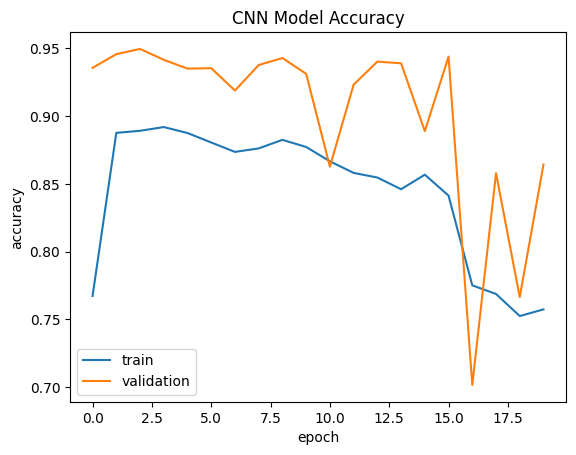

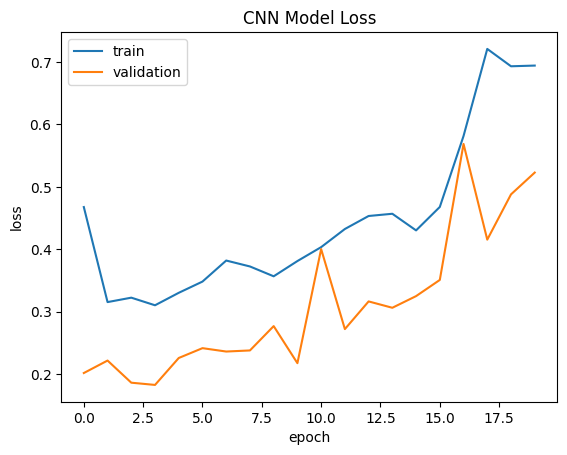

In [20]:
epochs= range(len(history.history["accuracy"]))
# accuracy plot
plt.plot(epochs, history.history["accuracy"])
plt.plot(epochs, history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("CNN Model Accuracy")
plt.legend(["train", "validation"])
plt.show()

# loss plot
plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CNN Model Loss")
plt.legend(["train", "validation"])
plt.show()

In [18]:
prediction= model_1.predict_generator(test_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=2)
prediction= prediction > 0.5
prediction

/tmp/ipykernel_43/55317336.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction= model_1.predict_generator(test_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=2)


792/792 - 26s - 26s/epoch - 33ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

0.864388580090955
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      7952
           1       0.80      0.98      0.88      7880

    accuracy                           0.86     15832
   macro avg       0.88      0.86      0.86     15832
weighted avg       0.88      0.86      0.86     15832



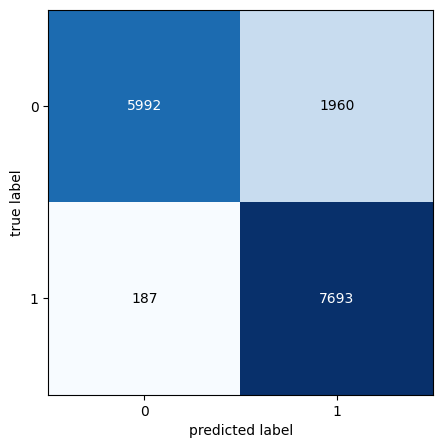

In [19]:
cm= confusion_matrix(test_data.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))

print(accuracy_score(test_data.classes, prediction))
print(classification_report(test_data.classes, prediction))